In [1]:
from __future__ import division, print_function, absolute_import

import cv2 as cv
from timeit import time
import numpy as np
from PIL import Image
from yolo import YOLO

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
from deep_sort.detection import Detection as ddet

import LaneDetection as ld
import math

/Users/mengwan/anaconda/envs/SSD/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [71]:
# Definition of the parameters
max_cosine_distance = 0.3
nn_budget = None
nms_max_overlap = 1.0

# deep_sort 
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

writeVideo_flag = False 

video_capture = cv.VideoCapture("./AB17-0830H_out.mp4")

if writeVideo_flag:
# Define the codec and create VideoWriter object
    w = int(video_capture.get(3))
    h = int(video_capture.get(4))
    fps = video_capture.get(cv.CAP_PROP_FPS)
    fourcc = cv.VideoWriter_fourcc(*'MP4V')
    out = cv.VideoWriter('output.mp4', fourcc, fps, (w, h))
    #list_file = open('detection.txt', 'w')
    frame_index = -1 

In [3]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


In [62]:
fps = 0.0
frame_count = 0
while True:
    if frame_count > 25:
        break
    ret, frame = video_capture.read()  # frame shape 640*480*3
    if ret != True:
        break;
    t1 = time.time()

    image = Image.fromarray(frame)
    boxs = yolo.detect_image(image)
    # print("box_num",len(boxs))
    features = encoder(frame,boxs)

    # score to 1.0 here).
    detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]

    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Call the tracker
    tracker.predict()
    tracker.update(detections)
    
    term = False
    for track in tracker.tracks:
        if track.is_confirmed() and track.time_since_update >1 :
            continue 
        bbox = track.to_tlbr()
        cv.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 2)
        #cv.putText(frame, str(track.track_id),(int(bbox[0]), int(bbox[1])),0, 5e-3 * 200, (0,255,0),2)
        
        '''visualize lane direction'''
        #if track.track_id == 11 and 
        if len(track.hist_bboxes)>10:
            centroids = [ld.centroid(bbox) for bbox in track.hist_bboxes]
            trend = ld.linreg(centroids)
            min_diff = 361
            assoc_lane = None
            for lane in ld.lanes:
                diff = abs(ld.slope_to_degree(trend[0]) - ld.slope_to_degree(lane.slope))
                if diff < min_diff:
                    min_diff = diff
                    assoc_lane = lane
                    bbox = track.to_tlbr()
                    #term = True
            cv.line(frame,
                    (int(ld.centroid(bbox)[0]), int(ld.centroid(bbox)[1])),
                    (int(bbox[0] + 100), int(bbox[1] + assoc_lane.slope * 100)),
                    (255,0,0),
                    5)
            
            area = lambda coords : (coords[2] - coords[0]) * (coords[3] - coords[1])
            bbox_change = area(track.hist_bboxes[0]) / area(track.hist_bboxes[1])
    
            length = lambda centroids : math.sqrt((centroids[1][0] - centroids[0][0])**2 + \
                                                  (centroids[1][1] - centroids[0][1])**2)
            len_travelled = length([ld.centroid(track.hist_bboxes[0]), ld.centroid(track.hist_bboxes[-1])]) / len(track.hist_bboxes)

            cv.putText(frame, 
                       "{:.4}".format(bbox_change/assoc_lane.average_bbox_change_ratio) + ' ' + "{:.4}".format(len_travelled/assoc_lane.average_bbox_speed),
                       (int(bbox[0]), int(bbox[1])),0, 5e-3 * 200, (0,255,0),2)
            #cv.imshow('', frame)
        '''
                print([l.slope for l in ld.lanes])
        if assoc_lane:
            print(str(trend[0]) + ' ' + str(lane.slope))
        '''
    if term:
        break
        
    for det in detections:
        bbox = det.to_tlbr()
        cv.rectangle(frame,(int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(0,255,0), 2)

    #cv.imshow('', frame)

    if writeVideo_flag:
        # save a frame
        out.write(frame)
        frame_index = frame_index + 1
        '''
        list_file.write(str(frame_index)+' ')
        if len(boxs) != 0:
            for i in range(0,len(boxs)):
                list_file.write(str(boxs[i][0]) + ' '+str(boxs[i][1]) + ' '+str(boxs[i][2]) + ' '+str(boxs[i][3]) + ' ')
        list_file.write('\n')
        '''
        #list_file.write('frame:' + str(frame_index) + '\n')
        for track in tracker.tracks:
            if track.is_confirmed() and track.time_since_update > 1 :
                continue 
            bbox = track.to_tlbr()
            #list_file.write('\ttrack:' + str(track.track_id) + ' ' + str(bbox[0]) + ' '+str(bbox[1]) + ' '+str(bbox[2]) + ' '+str(bbox[3]) +'\n')
                
    fps  = ( fps + (1./(time.time()-t1)) ) / 2
    print("fps= %f"%(fps))

    # Press Q to stop!
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
        
    frame_count += 1



fps= 0.104285
fps= 0.251391
fps= 0.366557
fps= 0.417506
fps= 0.443583
fps= 0.455635
fps= 0.446028
fps= 0.441834
fps= 0.458844
fps= 0.435462
fps= 0.447341
fps= 0.457116
fps= 0.423675
fps= 0.410921
fps= 0.409458
fps= 0.414124
fps= 0.422629
fps= 0.433323
fps= 0.405553
fps= 0.399494
fps= 0.437641
fps= 0.454409
fps= 0.468423
fps= 0.482177
fps= 0.481926
fps= 0.476850
fps= 0.481959
fps= 0.480028
fps= 0.465377
fps= 0.480157
fps= 0.485682
fps= 0.501336
fps= 0.487795
fps= 0.493040
fps= 0.491409
fps= 0.494916


In [70]:
video_capture.release()
if writeVideo_flag:
    out.release()
    list_file.close()
#cv.destroyAllWindows()

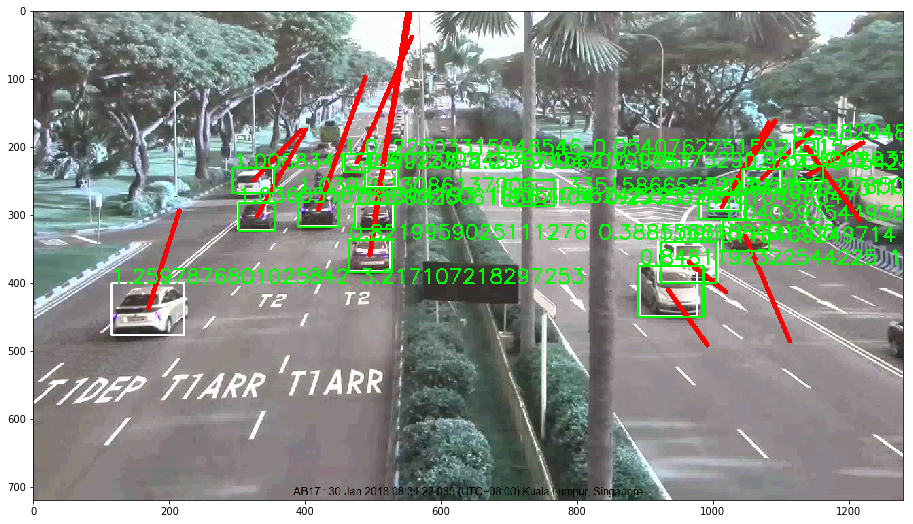

In [59]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
plt.imshow(frame)

In [63]:
track = tracker.tracks[7]
track.track_id

centroids = [ld.centroid(bbox) for bbox in track.hist_bboxes]
trend = ld.linreg(centroids)
min_diff = 361
assoc_lane = None
for lane in ld.lanes:
    diff = abs(ld.slope_to_degree(trend[0]) - ld.slope_to_degree(lane.slope))
    if diff < min_diff:
        min_diff = diff
        assoc_lane = lane
        bbox = track.to_tlbr()

area = lambda coords : (coords[2] - coords[0]) * (coords[3] - coords[1])
bbox_change = area(track.hist_bboxes[0]) / area(track.hist_bboxes[1])

length = lambda centroids : math.sqrt((centroids[1][0] - centroids[0][0])**2 + \
                                      (centroids[1][1] - centroids[0][1])**2)
len_travelled = length([ld.centroid(track.hist_bboxes[0]), ld.centroid(track.hist_bboxes[-1])]) / len(track.hist_bboxes)
    

In [68]:
test = "{:.4}".format(bbox_change/assoc_lane.average_bbox_change_ratio) + ' ' + "{:.4}".format(len_travelled/assoc_lane.average_bbox_speed)

In [69]:
print(test)

1.039 1.335


In [55]:
print(str(bbox_change) + " " + str(len_travelled))
len_travelled * bbox_change

1.0246640382916947 2.9722238342541827


2.900681319127225

In [57]:
for l in ld.lanes:
    print(str(l.average_bbox_change_ratio) + ' ' + str(l.average_bbox_speed) + ' ' + str(l.average_bbox_speed*l.average_bbox_change_ratio))

1.2115831245417275 4.2436920804726626 5.141585710452053
0.8907196071363147 6.12720099893529 5.4576180666168765
1.0302202469805957 0.6811501946220107 0.7017347217343686
0.9859162398807918 2.226120318534618 2.194768173971881
0.9607965151253706 3.70656880977067 3.5612583955000523
0.9572180356929096 1.105692347064875 1.0583886565381224
0.9635023443632033 2.756062824202557 2.6554729923314344
0.9487105613094007 1.6719267398365036 1.5861745558184857


In [54]:
assoc_lane.average_bbox_change_ratio

0.9859162398807918